In [1]:
import os
import sys
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from model_settings import ms
os.chdir(os.path.abspath(str(Path())))
pd.set_option("display.max_columns",None)
pd.options.display.float_format = '{:.5f}'.format
notebook_dir = str(Path().resolve())
root = Path().resolve().parent.parent
models_dir = os.path.join(root,ms.trained_models)
train_start = time.time()
train_start_datetime = datetime.fromtimestamp(train_start)
train_start_tag = train_start_datetime.strftime('%c')
print("\n"+"#"*18+"\n# training start #\n"+
      "#"*18+"\n"+f"\n{train_start_tag}\n")


##################
# training start #
##################

Thu Oct 31 10:30:09 2024



In [2]:
from convsklearn import barrier_trainer, asian_trainer
price = 'barrier_price' 
filetag = 'bloomberg barrier options'
trainer = barrier_trainer
datadir = os.path.join(root,ms.cboe_spx_barriers['dump'])

# loading data

In [3]:
files = [f for f in os.listdir(datadir) if f.endswith('.csv')]
files = [os.path.join(datadir,f) for f in files]
dfs = []
bar = tqdm(total=len(files)+1)
for f in files:
    dfs.append(pd.read_csv(f).iloc[:,1:])
    bar.update(1)
dataset = pd.concat(dfs,ignore_index=True).dropna().reset_index(drop=True)
bar.update(1)
bar.close()
dataset['calculation_date'] = pd.to_datetime(dataset['calculation_date'],format='%Y-%m-%d %H:%M:%S.%f')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:01<00:00, 220.06it/s]


# preprocessing

In [4]:
dataset[price] = pd.to_numeric(dataset[price],errors='coerce')
dataset['observed_price'] = np.maximum(dataset[price] + np.random.normal(scale=(0.15)**2,size=dataset.shape[0]),0)
dataset['calculation_date'] = pd.to_datetime(dataset['calculation_date'])
dataset = dataset.sort_values(by='calculation_date')
dataset = dataset.dropna().reset_index(drop=True)
unique_dates = dataset['calculation_date'].drop_duplicates().reset_index(drop=True).squeeze()
unique_dates

0     2024-09-25 15:59:46.089
1     2024-09-25 15:59:50.746
2     2024-09-25 16:00:55.624
3     2024-09-25 16:22:23.521
4     2024-09-25 16:25:01.274
                ...          
277   2024-10-15 14:26:15.994
278   2024-10-15 14:31:59.764
279   2024-10-15 15:57:40.633
280   2024-10-15 16:14:27.028
281   2024-10-15 16:50:04.131
Name: calculation_date, Length: 282, dtype: datetime64[ns]

## train/test split

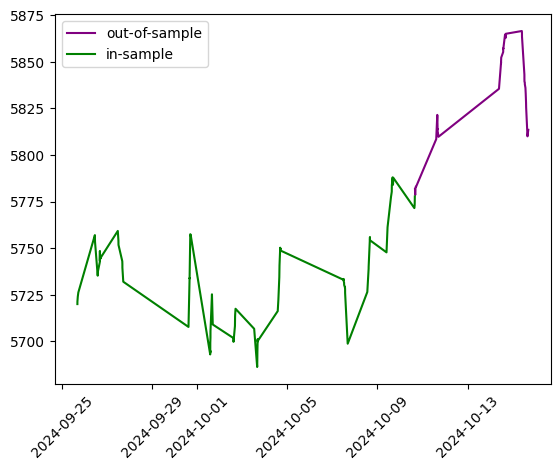

455760 153360


In [5]:
development_dates = unique_dates[:len(unique_dates)*3//4]
# development_dates = unique_dates[unique_dates<=pd.Timestamp(2008,9,1)]
test_dates = unique_dates[~unique_dates.isin(development_dates)]
train_data = dataset[dataset['calculation_date'].isin(development_dates)]
test_data = dataset[dataset['calculation_date'].isin(test_dates)]
train_plot = train_data[['calculation_date','spot_price']].copy().set_index('calculation_date').drop_duplicates()
test_plot = test_data[['calculation_date','spot_price']].copy().set_index('calculation_date').drop_duplicates()
plt.figure()
plt.xticks(rotation=45)
plt.plot(test_plot,color='purple',label='out-of-sample')
plt.plot(train_plot,color='green',label='in-sample')
plt.legend()
plt.show()
arrs = trainer.get_train_test_arrays(
    train_data, test_data)
preprocessor = trainer.preprocess()
train_X = arrs['train_X'] 
train_y = arrs['train_y']
test_X = arrs['test_X']
test_y = arrs['test_y']
print(len(train_y),len(test_y))

# training

# testing

In [6]:
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
trainer.dnn_params['max_iter'] = 1000
trainer.dnn_params

{'alpha': 0.01,
 'hidden_layer_sizes': (13, 13),
 'learning_rate': 'adaptive',
 'learning_rate_init': 0.1,
 'solver': 'sgd',
 'early_stopping': False,
 'max_iter': 1000,
 'warm_start': True,
 'tol': 0.0001}

In [7]:
mlp = make_pipeline(preprocessor, MLPRegressor(**trainer.dnn_params))

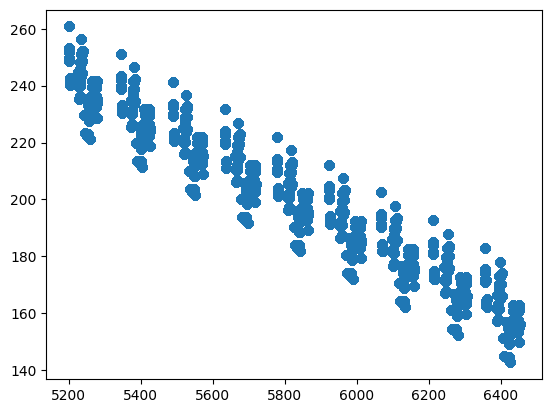

In [8]:
ridge_cols = ['spot_price','strike_price','kappa','theta','eta','rho','v0']

ridge_preprocessor = ColumnTransformer(transformers=[('scaling', StandardScaler(), ridge_cols)])

ridge = make_pipeline(ridge_preprocessor, Ridge(alpha=0.001))

ridge_fit = ridge.fit(train_X,train_y)

predictions = ridge_fit.predict(test_X)

K = test_X['strike_price'].squeeze().reset_index(drop=True)

P = pd.Series(predictions, name='predicted_value').reset_index(drop=True)

plt.figure()
plt.scatter(K,P)
plt.show()

In [ ]:
stacked_regressor = StackingRegressor(
    estimators=[
        ('ridge', ridge),
        ('mlp', mlp),
    ],
    final_estimator=GradientBoostingRegressor()
)

model_fit = stacked_regressor.fit(train_X,train_y)
end = time.time()
runtime = end-train_start
print(f"cpu: {runtime}")
model_fit

In [ ]:
insample, outsample, errors = trainer.test_prediction_accuracy(
        model_fit,
        test_data,
        train_data
)
outofsample_RMSE = errors['outofsample_RMSE']

# saving

In [ ]:
train_end = time.time()
train_end_tag = str(datetime.fromtimestamp(
    train_end).strftime("%Y_%m_%d %H%M%S%f"))
file_tag = str(train_end_tag + " " + filetag)
files_dir = os.path.join(models_dir,file_tag)

def save_model():
    if Path(files_dir).exists():
        pass
    else:
        os.mkdir(files_dir)
    file_dir = os.path.join(files_dir,file_tag)
    S = np.sort(train_data['spot_price'].unique())
    K = np.sort(train_data['strike_price'].unique())
    T = np.sort(train_data['days_to_maturity'].unique())
    W = np.sort(train_data['w'].unique())
    n_calls = train_data[train_data['w']=='call'].shape[0]
    n_puts = train_data[train_data['w']=='put'].shape[0]
    insample.to_csv(f"{file_dir} insample.csv")
    outsample.to_csv(f"{file_dir} outsample.csv")
    joblib.dump(model_fit,str(f"{file_dir}.pkl"))
    pd.set_option("display.max_columns",None)
    
    with open(f'{file_dir}.txt', 'w') as file:
        file.write(train_start_tag)
        file.write(f"\nspot(s):\n{S}")
        file.write(f"\n\nstrikes:\n{K}\n")
        file.write(f"\nmaturities:\n{T}\n")
        file.write(f"\ntypes:\n{W}\n")
        try:
            file.write(f"\n{train_data['barrier_type_name'].unique()}")
        except Exception:
            pass
        try:
            for col in ['averaging_type','fixing_frequency','past_fixings','n_fixings']:
                file.write(f"\n{col}:")
                file.write(f"\n{dataset[col].drop_duplicates().sort_values().values}\n")
        except Exception:
            pass
        file.write(f"\nnumber of calls, puts:\n{n_calls},{n_puts}\n")
        file.write(f"\ntotal prices:\n{train_data.shape[0]}\n")

        file.write("#"*17+"\n# training data #\n"+"#"*17+
              f"\n{train_data.describe()}\n")
        file.write("#"*13+"\n# test data #\n"+"#"*13+
              f"\n\n{test_data.describe()}\n")
        file.write(f"\n{dataset.dtypes}")
        file.write(
            f"\nin sample results:"
            f"\n     RMSE: {errors['insample_RMSE']}"
            f"\n     MAE: {errors['insample_MAE']}\n"
            f"\nout of sample results:"
            f"\n     RMSE: {errors['outofsample_RMSE']}"
            f"\n     MAE: {errors['outofsample_MAE']}\n"
            )
        file.write("\nfeatures:\n")
        for feature in trainer.feature_set:
            file.write(f"     {feature}\n")
        file.write(f"\ntarget: {trainer.target_name}\n")
        file.write(f"\ncpu: {train_runtime}\n")
        file.write(datetime.fromtimestamp(train_end).strftime('%c'))
        print(f"model saved to {file_dir}")

print(f"execute the command 'save_model()' to save the following model: {file_tag}")
train_runtime = train_end-train_start
print(f"\ncpu: {train_runtime}")